## Absolute change in 99th percentile 1-day accumulated precipitation
This notebook generates the text metadata files for the in-land flooding exposure metric `absolute change in 99th percentile 1-day accumulated precipitation`, using data from Cal-Adapt: Analytics Engine data. Because the AE data represents 200+ GB of data, metrics were calculated on the AE Jupyter Hub. 
Please see the processing script `climate_ae_precipitation_accumulation_metrics.py` for full methodological process.

In [1]:
import climakitae as ck
from climakitae.explore import warming_levels 
from climakitae.util.utils import add_dummy_time_to_wl
from climakitae.core.data_interface import DataParameters

import pandas as pd
import numpy as np
import geopandas as gpd

import pyproj
import rioxarray as rio
import xarray as xr

# projection information
import cartopy.crs as ccrs
crs = ccrs.LambertConformal(
    central_longitude=-70, 
    central_latitude=38, 
    false_easting=0.0, 
    false_northing=0.0,  
    standard_parallels=[30, 60], 
    globe=None, 
    # cutoff=-30
)

In [2]:
sims_wl = [
    'WRF_MPI-ESM1-2-HR_r3i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
    'WRF_MIROC6_r1i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
    'WRF_EC-Earth3_r1i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
    'WRF_TaiESM1_r1i1p1f1_Historical + SSP 3-7.0 -- Business as Usual',
]
sims_hist = [
    'WRF_MPI-ESM1-2-HR_r3i1p1f1',
    'WRF_MIROC6_r1i1p1f1', 
    'WRF_EC-Earth3_r1i1p1f1',
    'WRF_TaiESM1_r1i1p1f1', 
]

sim_name_dict = dict(zip(sims_wl,sims_hist)) 

In [3]:
def reproject_to_tracts(ds_delta, ca_boundaries):
    # this step takes about 12 minutes with 3km data (~1 min with 9km data)
    df = ds_delta.to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x,df.y))
    gdf = gdf.set_crs(crs)
    gdf = gdf.to_crs(ca_boundaries.crs)
    
    ca_boundaries = ca_boundaries.set_index(['GEOID'])    

    clipped_gdf = gpd.sjoin_nearest(ca_boundaries, gdf, how='left')
    clipped_gdf = clipped_gdf.drop(['index_right'], axis=1)
    clipped_gdf = clipped_gdf.reset_index()[
        ["GEOID",f"{ds_delta.name}","geometry"]]
    ### some coastal tracts do not contain any land grid cells ###
    
    # aggregate the gridded data to the tract level
    clipped_gdf_diss = clipped_gdf.reset_index().dissolve(
        by='GEOID', aggfunc='mean')
    clipped_gdf_diss = clipped_gdf_diss.rename(
        columns={f"{ds_delta.name}_right":
                 ds_delta.name}
    )
    
    # separate tracts with data from tracts without data
    clipped_gdf_nan = clipped_gdf_diss[np.isnan(
        clipped_gdf_diss[ds_delta.name]
    )]
    clipped_gdf_nan = clipped_gdf_nan[["geometry",ds_delta.name]]
    clipped_gdf_valid = clipped_gdf_diss[~np.isnan(
        clipped_gdf_diss[ds_delta.name]
    )]
    clipped_gdf_valid = clipped_gdf_valid[["geometry",ds_delta.name]]

    # compute the centroid of each tract
    clipped_gdf_nan["centroid"] = clipped_gdf_nan.centroid
    clipped_gdf_nan = clipped_gdf_nan.set_geometry("centroid")
    clipped_gdf_valid["centroid"] = clipped_gdf_valid.centroid
    clipped_gdf_valid = clipped_gdf_valid.set_geometry("centroid")
    
    # fill in missing tracts with values from the closest tract
    # in terms of distance between the tract centroids
    clipped_gdf_filled = clipped_gdf_nan.sjoin_nearest(clipped_gdf_valid, how='left')
    clipped_gdf_filled = clipped_gdf_filled[["geometry_left",f"{ds_delta.name}_right"]]
    clipped_gdf_filled = clipped_gdf_filled.rename(columns={
        "geometry_left":"geometry", f"{ds_delta.name}_right":ds_delta.name
    })
    clipped_gdf_valid = clipped_gdf_valid.drop(columns="centroid")
 
    # concatenate filled-in tracts with the original tract which had data
    gdf_all_tracts = pd.concat([clipped_gdf_valid,clipped_gdf_filled])

    return gdf_all_tracts


def min_max_standardize(df, col):
    '''
    Calculates min and max values for specified columns, then calculates
    min-max standardized values.

    Parameters
    ----------
    df: DataFrame
        Input dataframe   
    cols_to_run_on: list
        List of columns to calculate min, max, and standardize
    '''
    max_value = df[col].max()
    min_value = df[col].min()

    # Get min-max values, standardize, and add columns to df
    prefix = col # Extracting the prefix from the column name
    df[f'{prefix}_min'] = min_value
    df[f'{prefix}_max'] = max_value
    df[f'{prefix}_min_max_standardized'] = ((df[col] - min_value) / (max_value - min_value))

    # note to add checker to make sure new min_max column values arent < 0 > 1
    df[f'{prefix}_min_max_standardized'].loc[df[f'{prefix}_min_max_standardized'] < 0] = 0
    df[f'{prefix}_min_max_standardized'].loc[df[f'{prefix}_min_max_standardized'] > 1] = 1
    
    return df

### Step 1: Retrieve data
We need to calculate:
- 30 year centered around 2.0degC warming level (SSP3-7.0)
- Historical baseline 1981-2010 (Historical Climate)

Because "total precipitation" includes snow, we will also retrieve snowfall data so we can remove the snow signal and calculate rain. 

#### 1a) Chronic data (2.0degC WL)

In [4]:
# retrieve 2 deg C precipitation total data
wl = warming_levels()
wl.wl_params.timescale = "daily"
wl.wl_params.downscaling_method = "Dynamical"
wl.wl_params.variable = "Precipitation (total)"
wl.wl_params.area_subset = "states"
wl.wl_params.cached_area = ["CA"]
wl.wl_params.warming_levels = ["2.0"]
wl.wl_params.units = "mm"
wl.wl_params.resolution = "9 km"
wl.wl_params.anom = "No"
wl.calculate()
ds = wl.sliced_data["2.0"] # grab 2.0 degC data
ds = ds.sel(all_sims = list(sim_name_dict.keys()))
total_precip = add_dummy_time_to_wl(ds)
total_precip

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



Computing each warming level:   0%|          | 0/1 [00:00<?, ?it/s]

Processing data to read 3.52 GB of data into memory... 
[########################################] | 100% Completed | 130.28 s
Complete!


<xarray.DataArray 'Precipitation (total)' (warming_level: 1, time: 10950,
                                           y: 144, x: 60, all_sims: 4)>
array([[[[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]]]]], dtype=float32)
Coordinates:
  * warming_level      (warming_level) object '2.0'
  * time               (time) datetime64[ns] 2000-01-01 ... 2029-12-23
  * x                  (x) float64 -4.278e+06 -4.269e+06 ... -3.747e+06
  * y                  (y) float64 5.479e+05 5.569e+05 ... 1.826e+06 1.835e+06
    lakemask           (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    landmask           (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 30.96 31.01 31.05 ... 43.34 43.39 43.44
    lon                (y, x) float32 -117.9 -117.8 -117.7 ... -121.6 -121.5
    Lambert_Conformal  int64 0
    centered_year      (all_sims) int64 2045 2053 2034 2040
  * all_sims           (all_sims) <U70 'WRF_MPI-ESM1-2-HR_r3i1p1f1_Historical...
Attributes:
    variable_id:           prec
    extended_description:  Total precipitation. Computed by summing total gri...
    units:                 mm
    data_type:             Gridded
    resolution:            9 km
    frequency:             daily
    location_subset:       ['CA']
    grid_mapping:          Lambert_Conformal
    institution:           UCLA
    window:                15
    months:                [ 1  2  3  4  5  6  7  8  9 10 11 12]

In [5]:
# retrieve 2 deg C snowfall (snow and ice) data
wl.wl_params.timescale = "daily"
wl.wl_params.downscaling_method = "Dynamical"
wl.wl_params.variable = "Snowfall"
wl.wl_params.area_subset = "states"
wl.wl_params.cached_area = ["CA"]
wl.wl_params.warming_levels = ["2.0"]
wl.wl_params.units = "mm"
wl.wl_params.resolution = "9 km"
wl.calculate()
ds = wl.sliced_data["2.0"] # grab 2.0 degC data
ds = ds.sel(all_sims = list(sim_name_dict.keys()))
total_snowfall = add_dummy_time_to_wl(ds)
total_snowfall

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Returned data array is huge. Operations could take 10x to infinity longer than 1GB of data !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



Computing each warming level:   0%|          | 0/1 [00:00<?, ?it/s]

Processing data to read 3.52 GB of data into memory... 
[########################################] | 100% Completed | 81.65 s
Complete!


<xarray.DataArray 'Snowfall' (warming_level: 1, time: 10950, y: 144, x: 60,
                              all_sims: 4)>
array([[[[[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]],

         [[nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          ...,
          [nan, nan, nan, nan],
          [nan, nan, nan, nan],
          [nan, nan, nan, nan]]]]], dtype=float32)
Coordinates:
  * warming_level      (warming_level) object '2.0'
  * time               (time) datetime64[ns] 2000-01-01 ... 2029-12-23
  * x                  (x) float64 -4.278e+06 -4.269e+06 ... -3.747e+06
  * y                  (y) float64 5.479e+05 5.569e+05 ... 1.826e+06 1.835e+06
    lakemask           (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    landmask           (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 30.96 31.01 31.05 ... 43.34 43.39 43.44
    lon                (y, x) float32 -117.9 -117.8 -117.7 ... -121.6 -121.5
    Lambert_Conformal  int64 0
    centered_year      (all_sims) int64 2045 2053 2034 2040
  * all_sims           (all_sims) <U70 'WRF_MPI-ESM1-2-HR_r3i1p1f1_Historical...
Attributes:
    variable_id:           prec_snow
    extended_description:  Portion of the total precipitation in the form of ...
    units:                 mm
    data_type:             Gridded
    resolution:            9 km
    frequency:             daily
    location_subset:       ['CA']
    grid_mapping:          Lambert_Conformal
    institution:           UCLA
    window:                15
    months:                [ 1  2  3  4  5  6  7  8  9 10 11 12]

#### 1b) Retrieve historical baseline data (1981-2010)

In [6]:
## Step 1b: Retrieve historical baseline data (1981-2010)
# precip
selections = DataParameters()
selections.area_average = 'No'
selections.timescale = 'daily'
selections.variable = 'Precipitation (total)'
selections.area_subset = 'states'
selections.cached_area = ['CA']
selections.scenario_historical = ['Historical Climate']
selections.time_slice = (1981, 2010)
selections.resolution = '9 km'
selections.units = 'mm'
hist_precip_ds = selections.retrieve()
hist_precip_ds = hist_precip_ds.sel(simulation=sims_hist)
hist_precip_ds

# Snowfall (snow and ice)
selections.variable = 'Snowfall'
hist_snow_ds = selections.retrieve()
hist_snow_ds = hist_snow_ds.sel(simulation=sims_hist)
hist_snow_ds

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Returned data array is large. Operations could take up to 5x longer than 1GB of data!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Returned data array is large. Operations could take up to 5x longer than 1GB of data!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



,Array,Chunk
Bytes,1.41 GiB,21.97 MiB
Shape,"(1, 4, 10957, 144, 60)","(1, 1, 2131, 53, 51)"
Count,90 Graph Layers,576 Chunks
Type,float32,numpy.ndarray


### Step 2: Calculate delta signal
* remove snow from precip
* remove leap days from historical data
* pool the precipitation data together -- we do this becuase precipitation is better captured by collapsing the simulation dimension. Please see [internal_variability.ipynb](https://github.com/cal-adapt/cae-notebooks/blob/main/exploratory/internal_variability.ipynb) for a full explanation.

In [7]:
# remove snow from precip
rain_wl = total_precip - total_snowfall
rain_wl = rain_wl.clip(min=0.1)
rain_hist = hist_precip_ds - hist_snow_ds
rain_hist = rain_hist.clip(min=0.1)

In [8]:
# remove leap days from historical data
rain_hist = rain_hist.sel(time=~((rain_hist.time.dt.month == 2) & (rain_hist.time.dt.day == 29)))

In [9]:
# pool the data first
hist_pool = rain_hist.stack(index=['simulation', 'time']).squeeze()
wl_pool = rain_wl.stack(index=['all_sims', 'time']).squeeze()

In [10]:
hist_wrf_pool_perc = hist_pool.chunk(
    dict(index=-1)).quantile([.99],
    dim='index').compute().squeeze()

wl_wrf_pool_perc = wl_pool.chunk(
    dict(index=-1)).quantile([.99],
    dim='index').compute().squeeze()

delta_wrf_pool_perc = (wl_wrf_pool_perc - hist_wrf_pool_perc)
# absolute change in 99th percentile, data pooled

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


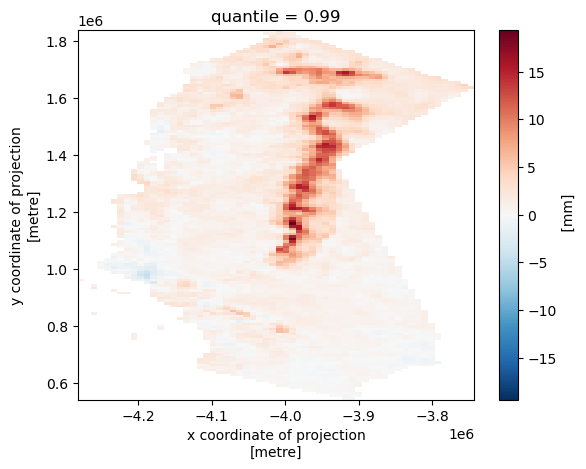

In [11]:
delta_wrf_pool_perc.plot()

In [12]:
# rename metric to be friendly for our remaining process
delta_wrf_pool_perc.name = "precip_99percentile"

### Step 3: Reproject data to census tract projection

In [14]:
# load in census tract shapefile
# census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/" # pcluster run
census_shp_dir = "2021_ca_tract/tl_2021_06_tract.shp" # local run, requires having census tracts loaded in file tree

ca_boundaries = gpd.read_file(census_shp_dir)

# convert to area-preserving CRS
ca_boundaries = ca_boundaries.to_crs(crs=3310)
rain_df = reproject_to_tracts(delta_wrf_pool_perc, ca_boundaries)

### Step 4: Min-max standardization

In [15]:
## Step 4: Min-max standardization
# Using Cal-CRAI min-max standardization function, available in `utils.calculate_index.py`
rain_std = min_max_standardize(rain_df, col=delta_wrf_pool_perc.name)

### Step 5: Export as csv

In [16]:
# clean up dataframes prior to export
rain_std = rain_std.drop(columns=['geometry'])

# export
rain_std.to_csv('climate_flood_exposure_precipitation_metric.csv')

In [17]:
rain_std

,precip_99percentile,precip_99percentile_min,precip_99percentile_max,precip_99percentile_min_max_standardized
GEOID,,,,
06001401700,1.009346,-1.807552,12.977818,0.190519
06001401800,1.009346,-1.807552,12.977818,0.190519
06001402200,1.009346,-1.807552,12.977818,0.190519
06001402500,1.009346,-1.807552,12.977818,0.190519
06001402600,1.009346,-1.807552,12.977818,0.190519
...,...,...,...,...
06111008900,1.700077,-1.807552,12.977818,0.237236
06111009100,1.700077,-1.807552,12.977818,0.237236
06111009200,1.700077,-1.807552,12.977818,0.237236
